<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/Embedding_Preproc_Functions_in_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embedding image preprocessing functions in a `tf.keras` model
> Learn how to embed an image preprocessing function in a `tf.keras` model.

- toc:true
- branch: master
- badges: true
- hide_binder_badge: true
- comments: true
- author: Sayak Paul
- categories: [tf.keras, preprocessing]

In this tutorial, we are going to see how to embed a simple image preprocessing function within a _trained model_ (`tf.keras`) while exporting it for serving. This is a useful feature to have because it can help us reduce a lot of boilerplate code needed while using any model for serving purposes. With this capability, you get a lot more flexibility and modularity to your model. 

In [0]:
#hide
# Import TenosrFlow and check version
import tensorflow as tf
print(tf.__version__)

2.2.0-rc2


In [0]:
#hide
# Other imports
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Data loading, ~preprocessing~, and visualization

To keep things simple we will be using the FashionMNIST dataset. Note that these techniques can easily be applied to more complex models as well (with some limitation). 

> We are **not** going to preprocess the images before hand. We will let the model do it. 

In [0]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [0]:
# Class labels (don't change the order)
CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

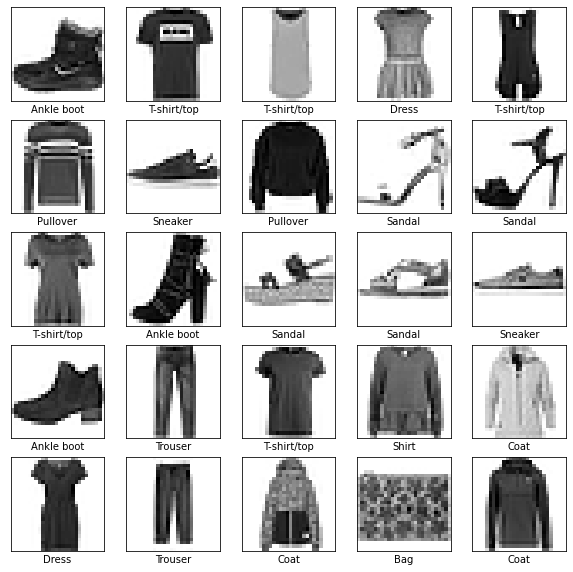

In [0]:
# Show a few examples from the train set
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(CLASSES[y_train[i]])
plt.show()

## Model building and training

We are good to proceed towards building and training a neural network. We will first define a simple preprocessing function to scale the pixel values and then we will embed it into the model using a [`Lambda` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda). You can replace this anything fancy you would want. 

We will use a shallow network architecture so that we can train it quickly. 



In [0]:
# Define the preprocessing function
# We will embed it in the model later
def preprocess_image(image_pixels):
    img = image_pixels / 255
    return img

# A humble model
def get_training_model():
    # Construct the model using the Functional API
    input_layer = tf.keras.layers.Input(shape=(28, 28), name="input_layer")
    preproc_layer = tf.keras.layers.Lambda(preprocess_image, name="lambda_layer")(input_layer) # Preprocessing function
    flatten = tf.keras.layers.Flatten()(preproc_layer)
    dense_1 = tf.keras.layers.Dense(128, activation="relu")(flatten)
    dropout = tf.keras.layers.Dropout(0.2)(dense_1)
    outputs = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(dropout)

    # Create the model
    model = tf.keras.models.Model(input_layer, outputs)

    # Compile the model and return it
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
        
    return model

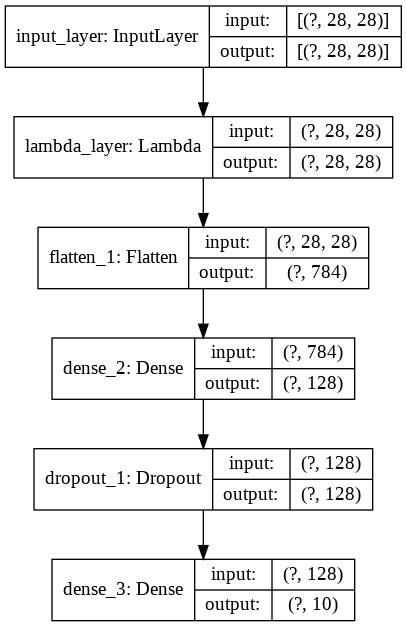

In [0]:
# Topology of the model
tf.keras.utils.plot_model(get_training_model(), show_shapes=True)

The `Lambda` layer is our preprocessing layer. 

In [0]:
# Train the model for 10 epochs
apparel_model = get_training_model()
history = apparel_model.fit(x_train, y_train, 
    validation_data=(x_test, y_test), 
    epochs=10, 
    batch_size=128)

Epoch 1/10
469/469 [==============================] - 2s 5ms/step - loss: 0.5972 - accuracy: 0.7929 - val_loss: 0.4448 - val_accuracy: 0.8413
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4170 - accuracy: 0.8512 - val_loss: 0.4205 - val_accuracy: 0.8498
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3813 - accuracy: 0.8626 - val_loss: 0.3885 - val_accuracy: 0.8578
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3570 - accuracy: 0.8701 - val_loss: 0.3675 - val_accuracy: 0.8687
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3408 - accuracy: 0.8762 - val_loss: 0.3607 - val_accuracy: 0.8686
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3275 - accuracy: 0.8808 - val_loss: 0.3520 - val_accuracy: 0.8715
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3165 - accuracy: 0.8832 - val_loss: 0.3437 - val_accuracy: 0.8778
Epoch 

Now that we have a trained model, we can go ahead and export it and then we will see how to use it on new images for inference. 

## Sample test image and model export

We are getting close. Now that we have a trained model here are the things we would do from here:
- Serialize a randomly selected image from the test set.  
- Export the model and parse model predictions. 

Let's go.

### Step 1: Serializing a randomly selected image from the test set

In [0]:
# Select a random image from the test set for serialization
sampe_test_img_id = np.random.choice(x_test.shape[0], 1)
sampe_test_img = x_test[sampe_test_img_id].squeeze() # Remove the batch dimension
sampe_test_img = (sampe_test_img * 255).astype("int32") # Scale back to integer

# Verify image label and shape
print("Image class: ",CLASSES[y_test[int(sampe_test_img_id)]])
print(sampe_test_img.shape)

Image class:  Shirt
(28, 28)


In [0]:
#hide_output
# Serialize the image
cv2.imwrite("sample_image.png", sampe_test_img)

True

Note that while writing a grayscale image, [OpenCV adds the channel dimension of 3 to it](https://stackoverflow.com/questions/18870603/in-opencv-python-why-am-i-getting-3-channel-images-from-a-grayscale-image). We will need to handle carefully. 

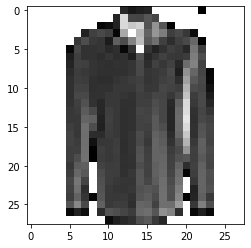

In [0]:
# Make sure the serialized image is good to go
plt.imshow(plt.imread("sample_image.png"), cmap=plt.cm.binary)
plt.show()

### Step 2: Model exporting and parsing predictions

Let's first serialize our model and load it. 

In [0]:
# Serialize the model and load it
apparel_model.save("apparel_model.h5")
restored_model = tf.keras.models.load_model("apparel_model.h5")

This warning is not desirable. When the optimizer is loaded with a fresh state, the model predictions can be erroneous. So, to resolve this problem we will only be serializing the weights of the model with the `save_weights()` function. There can be other nuances like this when you work with `Lambda` layers and you can check [this article](https://blog.paperspace.com/working-with-the-lambda-layer-in-keras/#saving-and-loading-a-model-with-a-lambda-layer) out to know about them. 

In [0]:
apparel_model.save_weights("apparel_model.h5")

We will now initialize a dummy model with the same architecture as the one we trained and we will then load the weights of our trained model into it. 

In [0]:
restored_model = get_training_model()
restored_model.load_weights("apparel_model.h5")

Now we should be good to go with the predictions part. First, let's load the image we serialized in step 1. As mentioned before, OpenCV adds 3-channels to grayscale images while saving them. We can take care of this issue with `cv2.cvtColor(image_pixels, cv2.COLOR_BGR2GRAY)`.

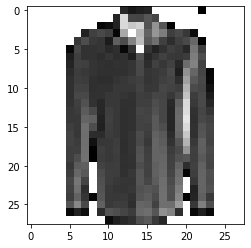

In [0]:
# Load the image
image_pixels = cv2.imread("sample_image.png")
image_pixels = cv2.cvtColor(image_pixels, cv2.COLOR_BGR2GRAY)

# Preview the image
plt.imshow(image_pixels, cmap=plt.cm.binary)
plt.show()

In [0]:
# Run inference and parse the prediction
class_probabilities = restored_model.predict(np.expand_dims(image_pixels, 0))[0]
print("Predicted ",CLASSES[np.argmax(class_probabilities)])

Predicted  Shirt


We can see that it is working as expected. 